In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
device = torch.device('cuda')
dtype = torch.float32
as_tensor = lambda x: torch.as_tensor(x, device=device, dtype=dtype)

Load perfect data

In [4]:
from utils_loading import load_data
from utils_3d import normalize_patches, disp3D, disp2D

In [5]:
dirname = "anisotropic-snr/blur=(5.0, 1, 1)_snr=50"
rootdir = f"/data/plumail/generated_data/inputs/{dirname}"
patches, coords, angles, views, poses, psf = map(as_tensor, load_data(rootdir))

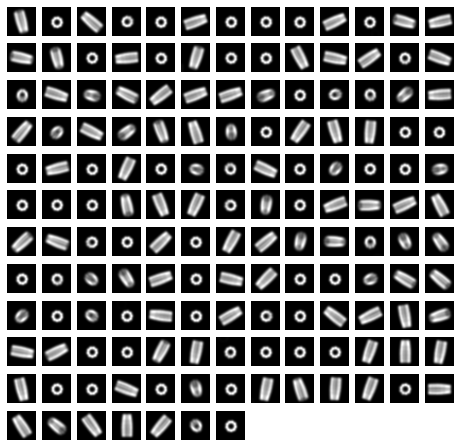

In [6]:
patches_2D = patches.sum(dim=1)
patches_2D = normalize_patches(patches_2D)

fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_2D.cpu().numpy(), cmap='gray')

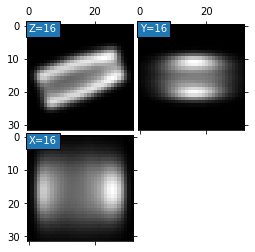

In [7]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, patches[5].cpu().numpy())

In [12]:
from utils_3d import affine_transform
import torch
from scipy.spatial.transform import Rotation as R

scipy.spatial.transform._rotation.Rotation

In [15]:
R.from_euler('ZXZ', poses[:,:3].cpu().numpy()).as_matrix()

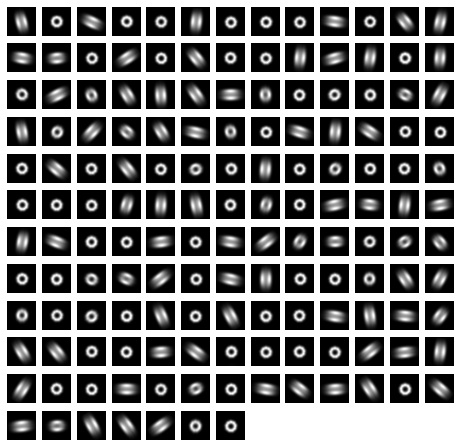

In [56]:
from importance_sampling.common_image_processing_methods.rotation_translation import rotation_gpu_pytorch as rotation

poses_no_rot = poses.clone()
poses_no_rot[:, :3] = 0
rot_mat = as_tensor(R.from_euler('XZX', poses[:,:3].cpu().numpy(), degrees=True).as_matrix())
tvec = poses[:, 3:]
patches_transformed = rotation(patches[:,None], rot_mat)[0][:,0]
patches_transformed_2D = patches_transformed.sum(dim=1)
patches_transformed_2D = normalize_patches(patches_transformed_2D)

fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_transformed_2D.cpu().numpy(), cmap='gray')

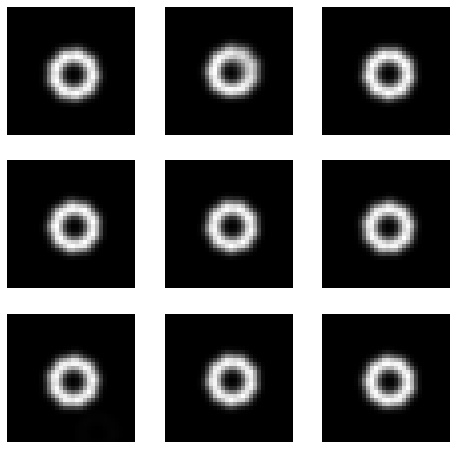

In [57]:
fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_2D[views==0][:9].cpu().numpy(), cmap='gray')

In [58]:
from scipy.ndimage import center_of_mass

cof = as_tensor([center_of_mass(patch.cpu().numpy()) for patch in patches])
cof_transformed = as_tensor([center_of_mass(patch.cpu().numpy()) for patch in patches_transformed])

In [59]:
cof[views==0][:9,[1,2]], poses[views==0][:9,[4,5]]

(tensor([[16.3399, 16.1511],
         [15.6326, 16.3472],
         [16.1987, 16.2397],
         [16.2201, 16.3780],
         [16.1319, 16.2946],
         [16.3530, 16.1512],
         [16.4337, 16.1451],
         [16.0856, 16.3280],
         [16.3800, 16.3790]], device='cuda:0'),
 tensor([[ 0.3832,  0.1742],
         [-0.2771,  0.3395],
         [ 0.2222,  0.2648],
         [ 0.2501,  0.4095],
         [ 0.1553,  0.3161],
         [ 0.3807,  0.1712],
         [ 0.3511,  0.1058],
         [ 0.1026,  0.3496],
         [ 0.4158,  0.4005]], device='cuda:0'))

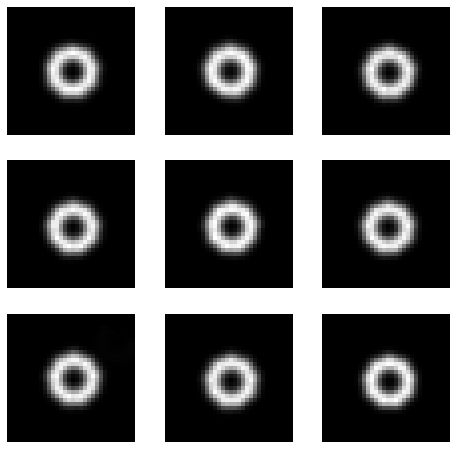

In [60]:
fig = plt.figure(figsize=(8,8))
disp2D(fig, *patches_transformed_2D[views==0][:9].cpu().numpy(), cmap='gray')

In [61]:
cof_transformed[views==0][:9,[1,2]], poses[views==0][:9,[4,5]]

(tensor([[15.6445, 15.8906],
         [15.4808, 15.8798],
         [15.8847, 16.2860],
         [16.4294, 16.0797],
         [16.2089, 16.2456],
         [16.3709, 16.0974],
         [15.6666, 16.3015],
         [16.3163, 16.1218],
         [16.3800, 16.3783]], device='cuda:0'),
 tensor([[ 0.3832,  0.1742],
         [-0.2771,  0.3395],
         [ 0.2222,  0.2648],
         [ 0.2501,  0.4095],
         [ 0.1553,  0.3161],
         [ 0.3807,  0.1712],
         [ 0.3511,  0.1058],
         [ 0.1026,  0.3496],
         [ 0.4158,  0.4005]], device='cuda:0'))

tensor([ 1.9376e+02,  1.1004e+02,  1.6595e+02, -1.0938e-01, -2.5194e-01,
        -4.8367e-01], device='cuda:0')
tensor([193.7556, 110.0416, 165.9466,   0.0000,   0.0000,   0.0000],
       device='cuda:0')


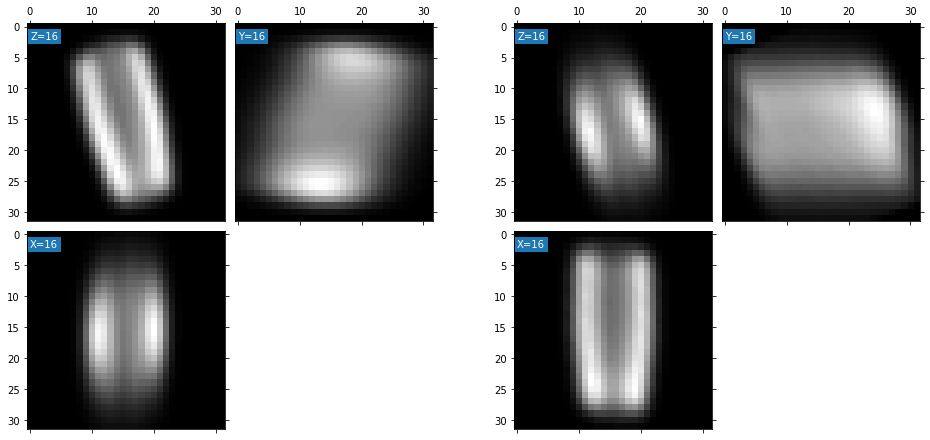

In [65]:
p = patches[0].clone()
pose = poses[0].clone()
print(pose)
pose[3:] = 0

print(pose)
p_transformed = rotation(patches[:1,None], rot_mat[:1])[0][0,0]

fig = plt.figure(figsize=(16,8))
disp3D(fig, p.cpu().numpy(), p_transformed.cpu().numpy())

Reconstruction L2

In [6]:
from utils_3d import reconstruction_L2

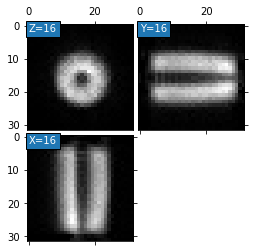

In [22]:
psf = psf / psf.sum()

lambda_ = as_tensor(5e-100000)
recon, den = reconstruction_L2(patches, psf, poses, lambda_)
fig = plt.figure(figsize=(4,4))
disp3D(fig, recon.cpu().numpy())

In [11]:
%timeit reconstruction_L2(patches, psf, poses, lambda_)

11.5 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
device = 'cpu'
%timeit reconstruction_L2(torch.as_tensor(patches, device=device), torch.as_tensor(psf, device=device), torch.as_tensor(poses, device=device), lambda_)

149 ms ± 4.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Based on the L2 reconstruction, find back the angles of the patches with the find_angles_grid function.

In [10]:
from utils_3d import find_angles_grid

best_poses, errors = find_angles_grid(recon, patches, psf, precision=10)

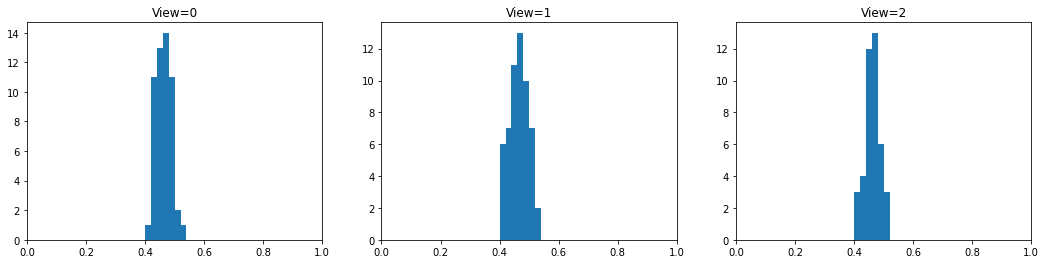

In [11]:
plt.figure(figsize=(6*3,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f"View={i}")
    plt.hist(errors[views==i].cpu().numpy(), bins=np.arange(0,1,0.02))
    plt.xlim(0,1)

Text(0.5, 1.0, 'Cross-correlation error vs angle error')

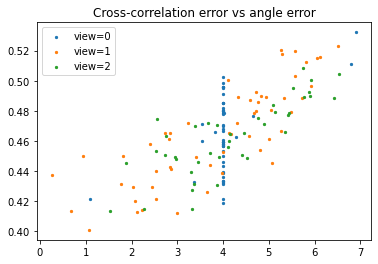

In [12]:
from utils_3d import distance_poses

angle, d = distance_poses(torch.as_tensor(poses, device=best_poses.device, dtype=best_poses.dtype), best_poses)
plt.figure(figsize=(6,4))
for i in range(3):
    plt.scatter(np.abs(angle[views==i].cpu().numpy()), errors[views==i].cpu().numpy(), s=5, label=f"view={i}")
plt.legend()
plt.title("Cross-correlation error vs angle error")

In [7]:
from utils_3d import affine_transform

In [13]:
N = 100
random_angles = np.random.random(size=(100,3)) * 360
random_poses = np.concatenate([random_angles, np.zeros((N,3))], axis=1)
device = 'cuda'
test_patches = affine_transform(recon[None].repeat(N,1,1,1)[:,None], as_tensor(random_poses))[:,0]


In [22]:
out = []
precision = np.geomspace(2, 30, num=10)[::-1]
for p in precision:
    print("precision =", p)
    best_poses, errors = find_angles_grid(recon, test_patches, psf, precision=p)
    angle, d = distance_poses(as_tensor(random_poses), best_poses)
    #angle[angle>90] = 180 - angle[angle>90]
    out.append(np.median(angle.cpu().numpy()))

precision = 30.0
precision = 22.204676389551587
precision = 16.434921785490328
precision = 12.164403991146798
precision = 9.003555136506147
precision = 6.664034272053467
precision = 4.93242414866094
precision = 3.6507627345675218
precision = 2.702133503203542
precision = 2.0


(0.0, 13.0)

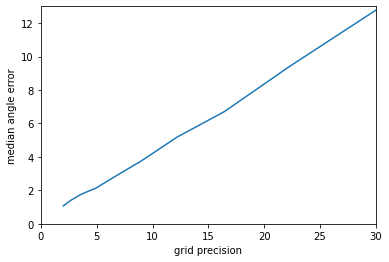

In [23]:
angle_error = np.stack(out)
plt.plot(precision, out)
plt.xlabel('grid precision')
plt.ylabel('median angle error')
plt.xlim(0, 30)
plt.ylim(0, 13)

Reconstruction L2 avec top et side seulement. Information sur l'angle relatif des sides.

tensor([[195.4386,  90.0000,  56.1341],
        [277.0149, 270.0000, 287.3436]], device='cuda:0')


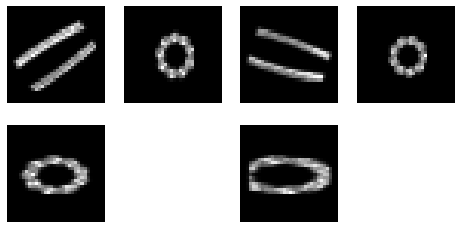

In [24]:
patches_side = patches[views==1]
fig = plt.figure(figsize=(8,4))
print(poses[views==1][[0,1],:3])
disp3D(fig, patches_side[0].cpu().numpy(), patches_side[1].cpu().numpy())

In [10]:
import os
import pickle
import napari

folder = "blur=(10.0, 1, 1)_snr=50"
data_dir = f"/data/plumail/generated_data/inputs/anisotropic-snr/{folder}"
#data_dir = f"/data/plumail/generated_data/inputs/perfect-10"
patches, coords, angles, views, poses, psf = load_data(data_dir)
patches, coords, views, poses, psf = as_tensor(patches), as_tensor(coords), as_tensor(views), as_tensor(poses), as_tensor(psf)
psf = psf / psf.sum()

In [85]:
from segmentation.data import SingleParticleGenerator_translation_holes

gen = SingleParticleGenerator_translation_holes(image_shape=(128,128,128), voxelise_res=30/4, psf_coef=(20.,2.,2.))
def create_dataset(generator, n):
    data = [generator({}) for i in range(n)]
    patches = torch.stack(list(map(lambda x:x[0], data)))
    poses = torch.zeros((n, 6))
    poses[:, :3] = torch.stack(list(map(lambda x:torch.tensor(x[2]['Rotate']['rotation_angles']), data)))
    poses[:, 3:] = torch.stack(list(map(lambda x:torch.tensor(x[2]['Translate']['tvec']), data)))
    psf = data[0][2]['ApplyPSF']['psf']
    return patches, poses, psf
patches, poses, psf = create_dataset(gen, 150)
side_views = (poses[:,1]-90).abs() < 10

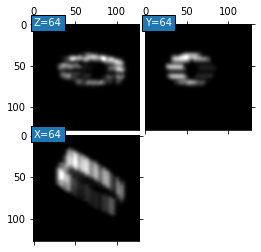

In [86]:
fig = plt.figure(figsize=(2*4,4))
disp3D(fig, patches[0].cpu().numpy())

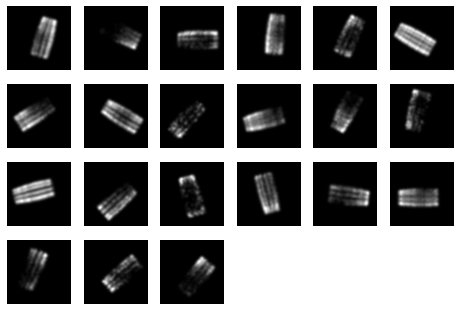

In [87]:
fig = plt.figure(figsize=(8,5.5))
disp2D(fig, *normalize_patches(patches[side_views].sum(dim=1)).cpu().numpy(), cmap='gray')

In [90]:
p_side_normlized = normalize_patches(patches[side_views].sum(dim=1)).cpu().numpy()
p_side_normlized += np.random.randn(*p_side_normlized.shape) * 0
from PIL import Image

for i, p in enumerate(p_side_normlized):
    Image.fromarray((p*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/side_generated_2/"+str(i)+".jpeg", "JPEG")


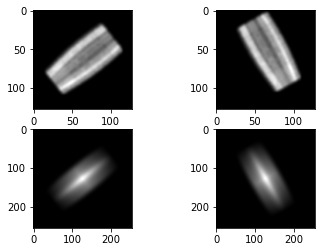

In [63]:
from scipy.signal import correlate
from scipy import ndimage as ndii

p0, p1 = p_side_normlized[0].copy(), p_side_normlized[2].copy()
p1 = ndii.shift(p1, (-10, 6))
acf0 = correlate(p0, p0)
acf1 = correlate(p1, p1)

Image.fromarray((p0*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/p0.jpeg", "JPEG")
Image.fromarray((p1*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/p1.jpeg", "JPEG")

Image.fromarray((((acf0-acf0.min())/(acf0.max()-acf0.min()))*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/acf0.jpeg", "JPEG")
Image.fromarray((((acf1-acf1.min())/(acf1.max()-acf1.min()))*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/acf1.jpeg", "JPEG")

from getPoses import polar

polar0 = polar(acf0)
polar1 = polar(acf1)
repeated_polar0 = np.concatenate([polar0, polar0], axis=0)
angular_correlation = correlate(repeated_polar0, polar1, mode='valid')

plt.subplot(221)
plt.imshow(p0, cmap='gray')
plt.subplot(222)
plt.imshow(p1, cmap='gray')
plt.subplot(223)
plt.imshow(acf0, cmap='gray')
plt.subplot(224)
plt.imshow(acf1, cmap='gray')

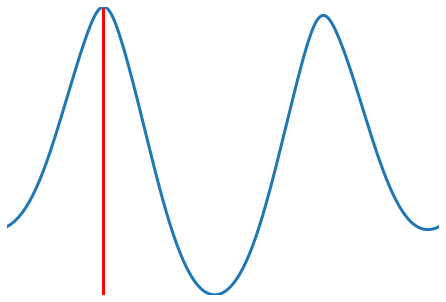

In [37]:
x = np.linspace(0, 360, angular_correlation.shape[0])
plt.axvline(80, color='red', lw=3)
plt.xlim(0, 360)
plt.plot(x, angular_correlation, lw=3)

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("/home/plumail/stage/rapport/assets/particles/frank_golfarb/angular_cross_corr.png", bbox_inches = 'tight',
    pad_inches = 0, transparent=True)

(128, 128) (128, 128)


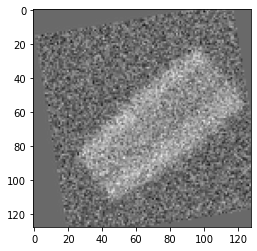

In [38]:
theta = x[angular_correlation.argmax()]
p1_rotated = ndii.rotate(p1, -theta, reshape=False)
print(p1.shape, p1_rotated.shape)
Image.fromarray((p1_rotated*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/p1_rotated.jpeg", "JPEG")
plt.imshow(p1_rotated, cmap='gray')

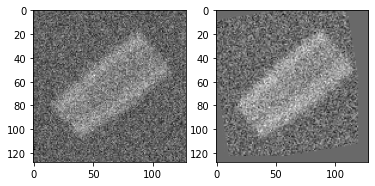

In [39]:
cross_corr = correlate(p0, p1_rotated, mode='full')
Image.fromarray((((cross_corr-cross_corr.min())/(cross_corr.max()-cross_corr.min()))*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/cross_corr.jpeg", "JPEG")

y, x = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
center = (cross_corr.shape[0]-1) / 2, (cross_corr.shape[1]-1) / 2
ty, tx = center[0] - y, center[1] - x
shift = (-ty, -tx)
p1_rotated_shifted = ndii.shift(p1_rotated, shift)
plt.subplot(121)
plt.imshow(p0, cmap='gray')
plt.subplot(122)
plt.imshow(p1_rotated_shifted, cmap='gray')

Image.fromarray((p1_rotated_shifted*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/frank_golfarb/p1_rotated_shifted.jpeg", "JPEG")

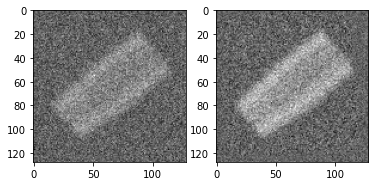

In [40]:
plt.subplot(121)
plt.imshow(p0, cmap='gray')
plt.subplot(122)
plt.imshow(p0+p1_rotated_shifted, cmap='gray')

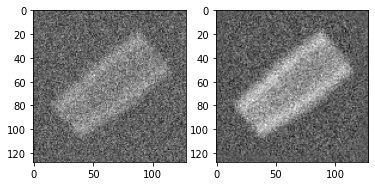

In [44]:
from getPoses import get_transform, transform_patch

avrg1 = p0+p1_rotated_shifted
p2 = p_side_normlized[4].copy()
R, ty, tx = get_transform(avrg1, p2)
p2_transformed = transform_patch(p2, R, ty, tx)

avrg2 = p2_transformed + avrg1

plt.subplot(121)
plt.imshow(p0, cmap='gray')
plt.subplot(122)
plt.imshow(avrg2, cmap='gray')

In [102]:
N = p_side_normlized.shape[0]
avrg = p_side_normlized[0].copy() / N
transforms = []
for i in range(p_side_normlized.shape[0]-1):
    p = p_side_normlized[i+1].copy()
    R, ty, tx = get_transform(avrg, p)
    transforms.append((R,ty,tx))
    p_transformed = transform_patch(p, R, ty, tx)

    avrg += p_transformed / N

    Image.fromarray(((avrg-avrg.min())/(avrg.max()-avrg.min())*255).astype(np.uint8), "L").save(f"/home/plumail/stage/rapport/assets/particles/penczek/etape-a/avrg-{i}.jpeg", "JPEG")

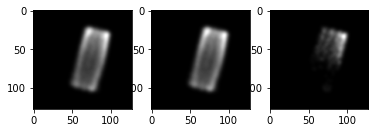

In [109]:
N = p_side_normlized.shape[0]

avrg2 = avrg * (N-1)/N - transform_patch(p_side_normlized[1], *transforms[0]) / N
plt.subplot(131)
plt.imshow(avrg, cmap='gray')
plt.subplot(132)
plt.imshow(avrg2, cmap='gray')
plt.subplot(133)
plt.imshow(transform_patch(p_side_normlized[1], *transforms[0]), cmap='gray')

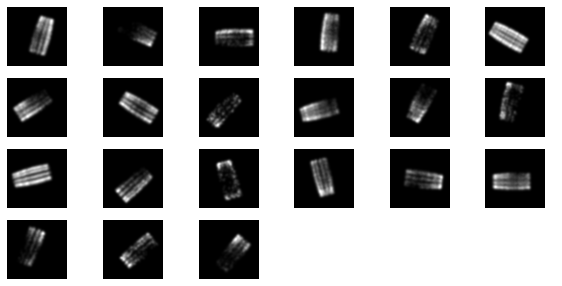

In [128]:
fig = plt.figure(figsize=(10,5))
disp2D(fig, *p_side_normlized, cmap='gray')

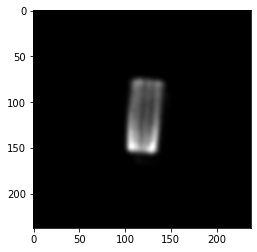

[21, 3, [20, 15, [19, 1, [18, 6, [17, 20, [16, 9, [15, 17, [14, 16, [13, 13, [12, 8, [11, 7, [10, 0, [9, 4, [8, 18, [7, 10, [6, 11, [5, 14, [4, 19, [3, 12, [2, 2, 5, (329.6842105263158, 4.0, -11.0)], (347.11578947368423, -5.0, 8.0)], (327.41052631578947, 2.0, -4.0)], (478.61052631578946, 1.0, 0.0)], (209.55789473684212, -4.0, -3.0)], (12.126315789473685, 14.0, 0.0)], (534.6947368421053, 4.0, 2.0)], (2.2736842105263158, 5.0, -7.0)], (352.42105263157896, 1.0, 3.0)], (287.62105263157895, 2.0, 1.0)], (281.93684210526317, 7.0, -5.0)], (9.852631578947369, -1.0, 2.0)], (229.26315789473685, 1.0, 0.0)], (530.9052631578948, 0.0, 4.0)], (346.3578947368421, 1.0, -7.0)], (496.8, -6.0, 3.0)], (208.0421052631579, -3.0, 4.0)], (229.26315789473685, 6.0, 6.0)], (50.77894736842106, -15.0, -3.0)], (20.46315789473684, -2.0, -1.0)]
5 [245.17894737  10.96594719   3.16136606]


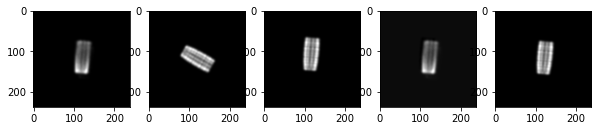

1 [71.24210526 17.22339938  3.23768716]


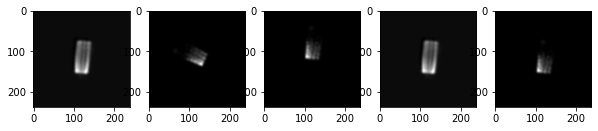

17 [271.70526316  -2.29633619 -13.24679417]


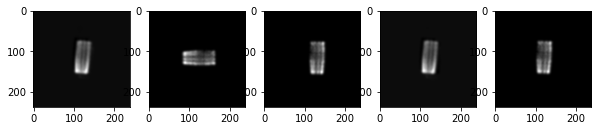

4 [163.70526316   3.4804612  -10.28642824]


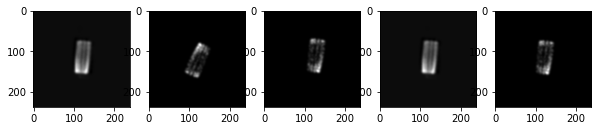

10 [340.67368421  10.74374784 -14.70306435]


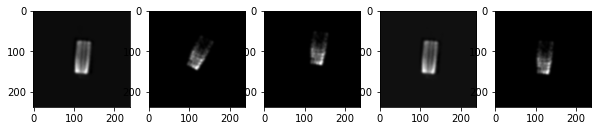

11 [352.8          1.00427484 -10.3189125 ]


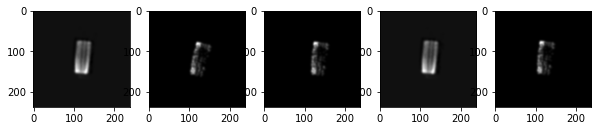

3 [0. 0. 0.]


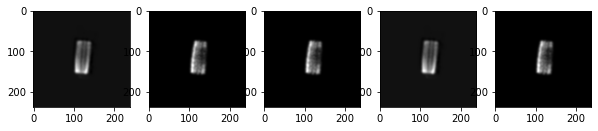

16 [82.61052632 13.17259305 -6.68951815]


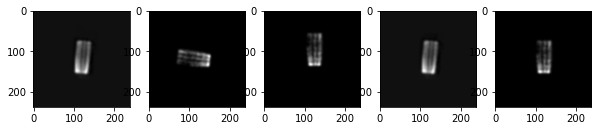

7 [243.66315789   8.54701449  -2.7530381 ]


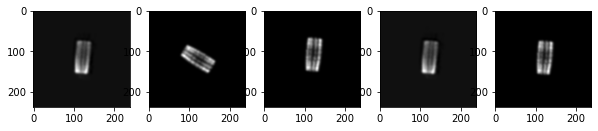

15 [20.46315789  2.          1.        ]


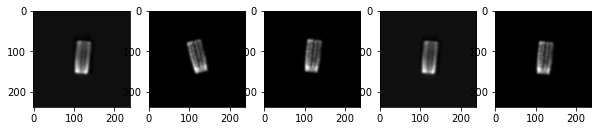

0 [171.28421053  -3.32458563   7.88122449]


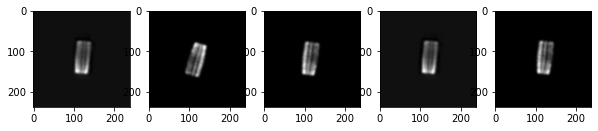

14 [202.35789474   6.28965851  -7.11167578]


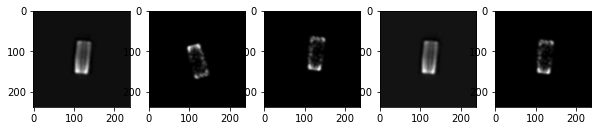

19 [320.96842105  -4.11162223   8.96958993]


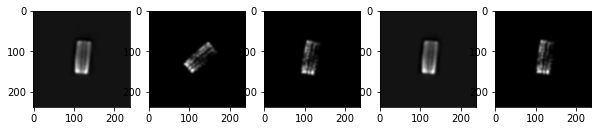

2 [275.49473684  -6.36956137 -15.64776166]


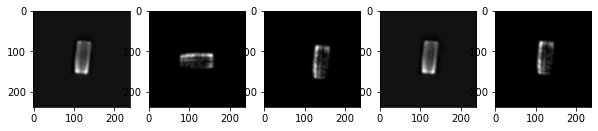

12 [288.37894737 -10.84249092   8.37827995]


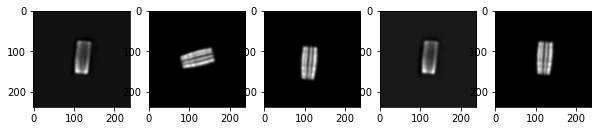

18 [165.97894737 -11.22680582  15.8966907 ]


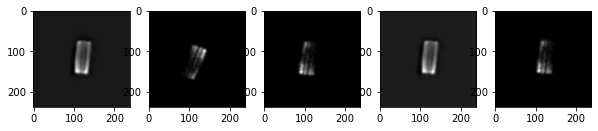

20 [148.54736842  22.6456251  -12.55195575]


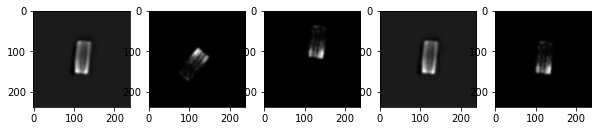

13 [311.87368421  -5.93978836 -13.92355385]


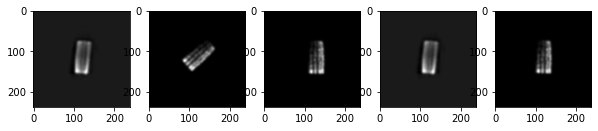

6 [300.50526316   2.60424758 -21.26744995]


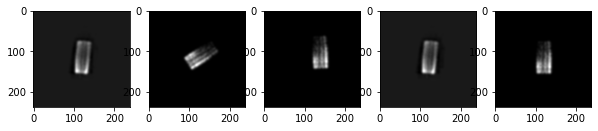

8 [321.72631579   7.40297858 -15.71671618]


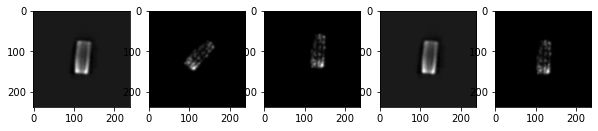

9 [285.34736842 -19.86787375  -4.10861951]


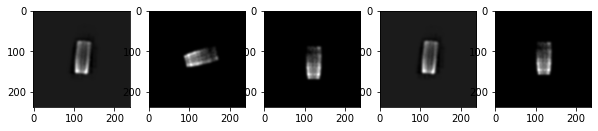

16 [443  -5  -3]


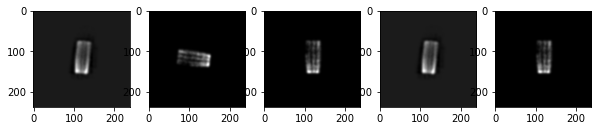

20 [506 -16  -3]


KeyboardInterrupt: 

<Figure size 720x360 with 0 Axes>

In [175]:
from getPoses import iterative_suppression, iterative_alignment, transform_patch

params_side, avrg_particle_side, variance_map_side = iterative_alignment(p_side_normlized)

side_patches_2D_aligned = np.stack([transform_patch(patch, R, ty, tx, pad=True) for patch, (R,ty,tx) in zip(p_side_normlized, params_side)])

plt.subplot(121)
plt.imshow(avrg_particle_side, cmap='gray')
plt.subplot(122)
plt.imshow(avrg, cmap='gray')

In [32]:
for i, p in enumerate(side_patches_2D_aligned):
    Image.fromarray((p*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/side_generated_aligned/"+str(i)+'.jpeg', "JPEG")

In [37]:
side_patches_2D_aligned_x = np.stack([transform_patch(patch, R+57.5, ty, tx, pad=True) for patch, (R,ty,tx) in zip(p_side_normlized, params_side)])
for i, p in enumerate(side_patches_2D_aligned_x):
    Image.fromarray((p*255).astype(np.uint8), "L").save("/home/plumail/stage/rapport/assets/particles/side_generated_aligned_x/"+str(i)+'.jpeg', "JPEG")

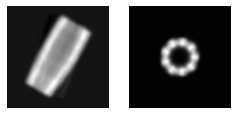

In [12]:
from getPoses import iterative_suppression, iterative_alignment

side_patches_2D = patches[views==1].sum(dim=1).cpu().numpy()
top_patches_2D = patches[views==0].sum(dim=1).cpu().numpy()
params_side, avrg_particle_side, variance_map_side = iterative_alignment(side_patches_2D)
params_top, avrg_particle_top, variance_map_top = iterative_alignment(top_patches_2D)

fig = plt.figure(figsize=(4,8))
disp2D(fig, avrg_particle_side, avrg_particle_top, cmap='gray')

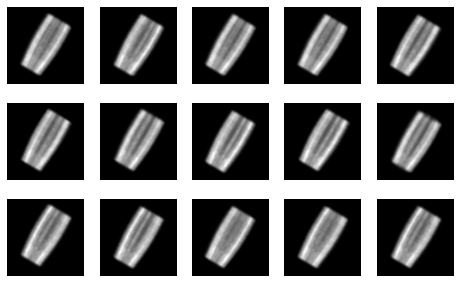

In [31]:
from getPoses import transform_patch

side_patches_2D_aligned = np.stack([transform_patch(patch, R, ty, tx, pad=True) for patch, (R,ty,tx) in zip(side_patches_2D, params_side)])

fig = plt.figure(figsize=(8,5))
disp2D(fig, *side_patches_2D_aligned[:-2], cmap='gray')

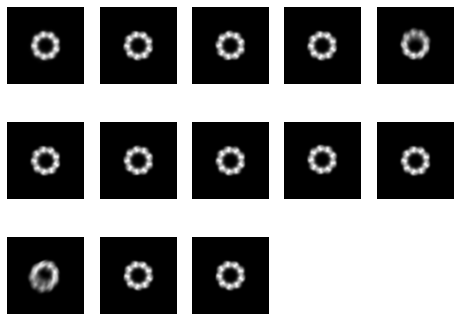

In [10]:
top_patches_2D_aligned = np.stack([transform_patch(patch, R, ty, tx, pad=True) for patch, (R,ty,tx) in zip(top_patches_2D, params_top)])

fig = plt.figure(figsize=(8,6))
disp2D(fig, avrg_particle_top, *top_patches_2D_aligned, cmap='gray')

In [14]:
from utils_3d import inverse_affine_transform, affine_transform, reconstruction_L2

lambda_ = as_tensor(5e-5)
poses_noised = torch.zeros_like(poses)

# Reset translations
#poses_noised[:, 3:] = 0

# Noise to angles
#poses_noised[:, :3] += torch.randn_like(poses_noised[:,:3]) * sigma # désaligne les particules side légèrement

# Top views
poses_noised[views==0, 1] = 0 # known
poses_noised[views==0, 2] = -as_tensor(params_top[:, 0])
poses_noised[views==0, 4:6] = -as_tensor(params_top[:, 1:3])

# Side views
poses_noised[views==1, 1] = 90
poses_noised[views==1, 2] = -as_tensor(params_side[:, 0])
poses_noised[views==1, 4:6] = -as_tensor(params_side[:, 1:3])


mask_top_side = torch.logical_or(views==0, views==1)

step = 1
delta = as_tensor(torch.arange(0, 360, step)[:,None])
M = delta.size(0)
poses_noised = poses_noised[None].repeat(M,1,1)
poses_noised[:,views==1,2] += delta

print(M, mask_top_side.sum())

360 tensor(29, device='cuda:0')


In [ ]:
recon_noised, _ = reconstruction_L2(patches[mask_top_side], psf, poses_noised[:,mask_top_side], lambda_[None].repeat(M))

/home/plumail/stage/SPFluo_stage_reconstruction_symmetryC/utils_3d.py:79: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  euler_angles = transform_[...,:3].cpu().numpy()


torch.Size([360])


Text(0, 0.5, 'MSE reconstruction L2')

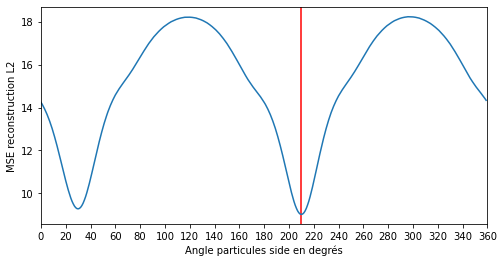

In [16]:
MSE = torch.empty((recon_noised.size(0),))
for i in range(recon_noised.size(0)):
    patches_noised_transformed = inverse_affine_transform(patches[mask_top_side][:,None], poses_noised[i, mask_top_side])[:,0]
    MSE[i] = ((recon_noised[i] - patches_noised_transformed) ** 2).view(-1).mean() / patches[mask_top_side].size(0)
print(MSE.shape)
plt.figure(figsize=(8,4))
plt.xticks(np.arange(0, 361, 20))
plt.xlim(0, 360)
#plt.axvline(random_first_angle.cpu().numpy(), color='green')
plt.axvline(delta.cpu().numpy()[MSE.argmin()], color='red')
plt.plot(delta.cpu().numpy(), MSE.cpu().numpy())
plt.xlabel('Angle particules side en degrés')
plt.ylabel('MSE reconstruction L2')

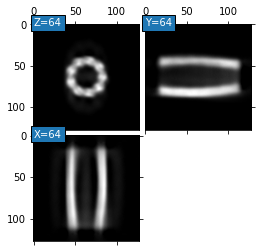

In [17]:
fig = plt.figure(figsize=(4,4))
disp3D(fig, recon_noised[MSE.argmin()].cpu().numpy())

torch.Size([17, 6])

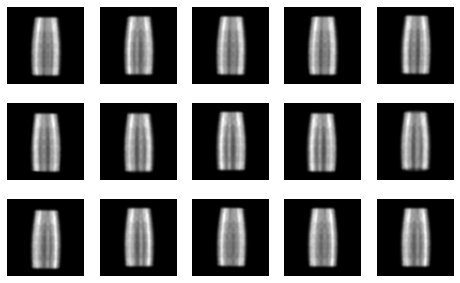

In [40]:
side_patches_2D_aligned_absolute = np.stack([transform_patch(patch, -R, ty, tx, pad=True) for patch, (_,_,R,_,ty,tx) in zip(side_patches_2D, poses_noised[MSE.argmin(),views==1].cpu().numpy())])

fig = plt.figure(figsize=(8,5))
disp2D(fig, *side_patches_2D_aligned_absolute[:-2], cmap='gray')

In [20]:
import napari
napari.view_image(recon_noised[MSE.argmin()].cpu().numpy())

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 63.5, 63.5), zoom=5.6109374999999995, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 128.0, 1.0), (0.0, 128.0, 1.0), (0.0, 128.0, 1.0)), current_step=(64, 64, 64), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f2ecb079250>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=Fals

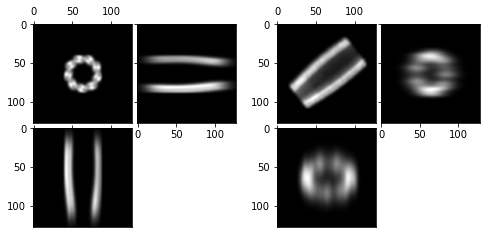

In [15]:
fig = plt.figure(figsize=(2*4,4))
disp3D(fig, patches[views==0][0].cpu().numpy(), patches[views==1][0].cpu().numpy())

Test sur différents niveaux de bruits

In [20]:
import os
import pickle
import glob
import torch

from utils_3d import first_reconstruction

os.chdir('/home/plumail/stage/minisource')

data_dirs = glob.glob("/data/plumail/generated_data/inputs/inputs*")
device = 'cuda'
dtype = torch.float32
out = []
as_tensor = lambda x: torch.as_tensor(x, dtype=dtype, device=device)
for data_dir in data_dirs:
    config_path = os.path.join(data_dir, 'config.pickle')
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
    patches, coords, angles, views, poses, psf = load_data(data_dir)
    delta, recon, error = first_reconstruction(as_tensor(patches), as_tensor(views), as_tensor(poses), as_tensor(psf), step=1)
    out.append((config.sensor.anisotropic_blur_sigma, config.sensor.gaussian_noise_target_snr_db, delta, recon, error))

/home/plumail/stage/minisource/utils_3d.py:62: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  transform_[:,:3] = torch.as_tensor(Rotation.from_euler('zxz', euler_angles, degrees=True).inv().as_euler('zxz', degrees=True).copy(), device=transform.device, dtype=transform.dtype)


In [53]:
import pandas as pd

df = pd.DataFrame(list(map(lambda x:(x[0][0],x[1],x[2].cpu().item(),x[4].cpu().item()), out)), columns=["anisotropic_blur","gaussian_nois_snr","delta","error"])
df["delta"] = df["delta"].astype(float) % 180
df.loc[df["delta"] > 90, "delta"] = df[df["delta"] > 90]["delta"] - 180
df.head()

,anisotropic_blur,gaussian_nois_snr,delta,error
0,9.0,11.111111,-2.0,10947.177734
1,8.0,5.555556,-5.0,10654.317383
2,3.0,5.555556,-2.0,8924.691406
3,4.0,0.000000,-2.0,9242.033203
4,10.0,5.555556,-8.0,11575.143555


Text(0, 0.5, 'erreur angle')

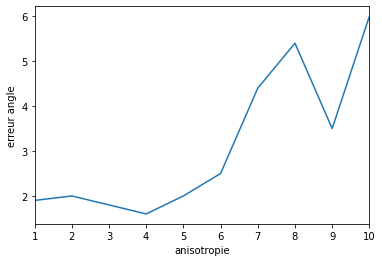

In [66]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('anisotropic_blur').mean()['delta_abs'])
plt.xlim(1, 10)
plt.xlabel("anisotropie")
plt.ylabel("erreur angle")

Text(0, 0.5, 'erreur angle')

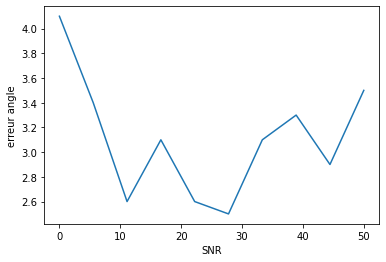

In [74]:
df["delta_abs"] = df["delta"].abs()

plt.plot(df.groupby('gaussian_nois_snr').mean()['delta_abs'])
#plt.xlim(1, 10)
plt.xlabel("SNR")
plt.ylabel("erreur angle")

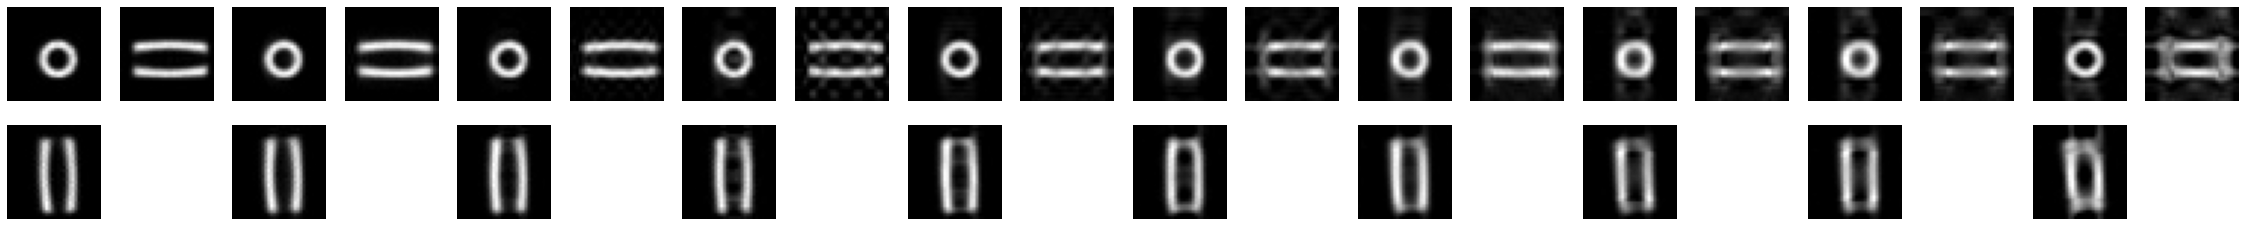

In [64]:
snr_vals = sorted(list(set(map(lambda x:x[1], out))))
recons = list(filter(lambda x:x[1]==snr_vals[0], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

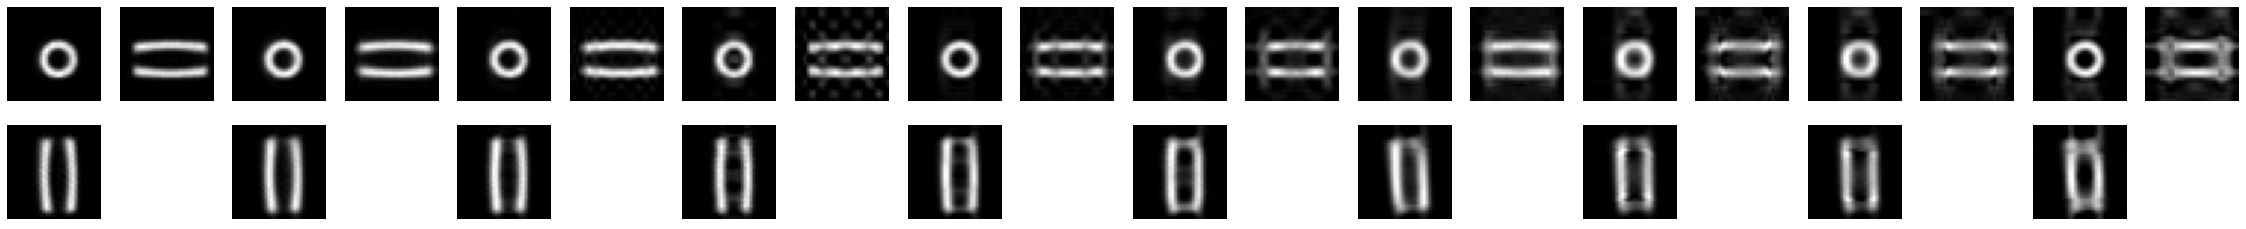

In [65]:
recons = list(filter(lambda x:x[1]==snr_vals[-1], out))
recons = sorted(recons, key=lambda x:x[0][0])
fig = plt.figure(figsize=(10*4,4))
disp3D(fig, *[x[3].cpu().numpy() for x in recons])

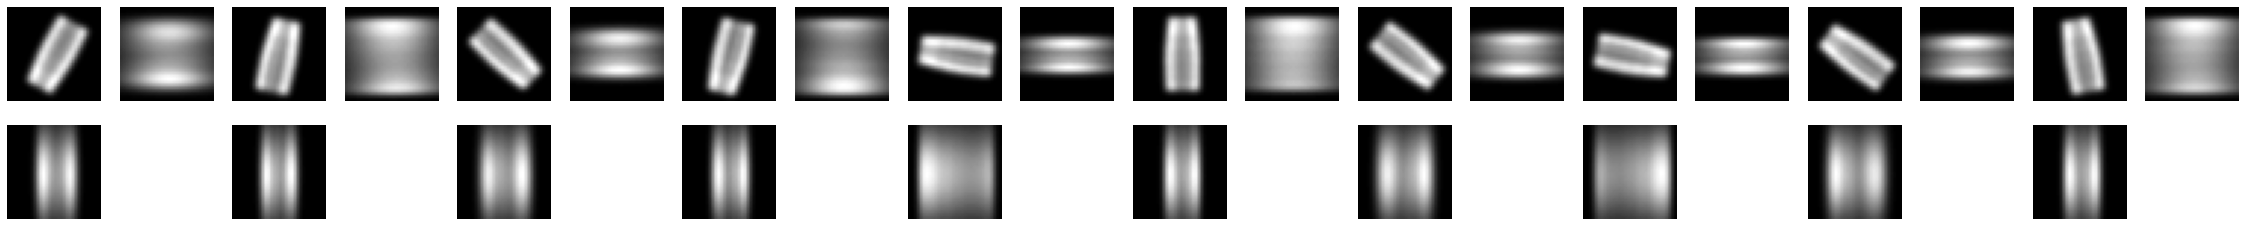

In [72]:
patches, coords, angles, views, poses, psf = load_data("/data/plumail/generated_data/inputs/inputs_blur=10.0_snr=11.11111111111111")
fig = plt.figure(figsize=(4*10,4))
disp3D(fig, *patches[views==1][:10])